Summary.
1. **Air quality is better in warmer months**, compared to colder months.
2. **Air quality gets better, the further you go from downtown LA**. I gave each data point an additional point of information, distance as measured by the haversine formula. There’s a moderate negative correlation with distance from central LA and AQI value of -0.31.
3. **Lancaster air quality is worst than expected**.
4. **Air quality is good on most days, with the exception of a few days, such as wildfires.**
5. **Machine learning models trained with linear regression, decision tree, and transformer predict AQI (air quality index) fairly well** with PM2.5, month, and distance from central LA as features. Linear regression has an R2 score of 0.94, decision tree with 0.99, and transformer with 0.99.

Loading the Data

In [1]:
import pandas as pd

# Load the dataset
file_path = '/Los_Angeles_Air_Quality_2010-2022.csv'
air_quality_data = pd.read_csv(file_path)

Data Exploratory Analysis

In [2]:
# Display the first few rows of the dataset and its summary information
air_quality_data.head(), air_quality_data.info(), air_quality_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61105 entries, 0 to 61104
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Date                            61105 non-null  object 
 1   Source                          61105 non-null  object 
 2   Site ID                         61105 non-null  int64  
 3   POC                             61105 non-null  int64  
 4   Daily Mean PM2.5 Concentration  61105 non-null  float64
 5   UNITS                           61105 non-null  object 
 6   DAILY_AQI_VALUE                 61105 non-null  int64  
 7   Site Name                       61105 non-null  object 
 8   DAILY_OBS_COUNT                 61105 non-null  int64  
 9   PERCENT_COMPLETE                61105 non-null  float64
 10  AQS_PARAMETER_CODE              61105 non-null  int64  
 11  AQS_PARAMETER_DESC              61105 non-null  object 
 12  CBSA_CODE                       

(         Date Source   Site ID  POC  Daily Mean PM2.5 Concentration     UNITS  \
 0  2010-01-01    AQS  60371103    3                            15.9  ug/m3 LC   
 1  2010-01-01    AQS  60374004    1                            26.5  ug/m3 LC   
 2  2010-01-01    AQS  60376012    3                             5.8  ug/m3 LC   
 3  2010-01-01    AQS  60371103    1                            13.1  ug/m3 LC   
 4  2010-01-01    AQS  60371002    1                            21.8  ug/m3 LC   
 
    DAILY_AQI_VALUE                      Site Name  DAILY_OBS_COUNT  \
 0               59  Los Angeles-North Main Street                1   
 1               81             Long Beach (South)                1   
 2               24                  Santa Clarita                1   
 3               53  Los Angeles-North Main Street                1   
 4               71                        Burbank                1   
 
    PERCENT_COMPLETE  ...                      AQS_PARAMETER_DESC CBSA_CODE  \

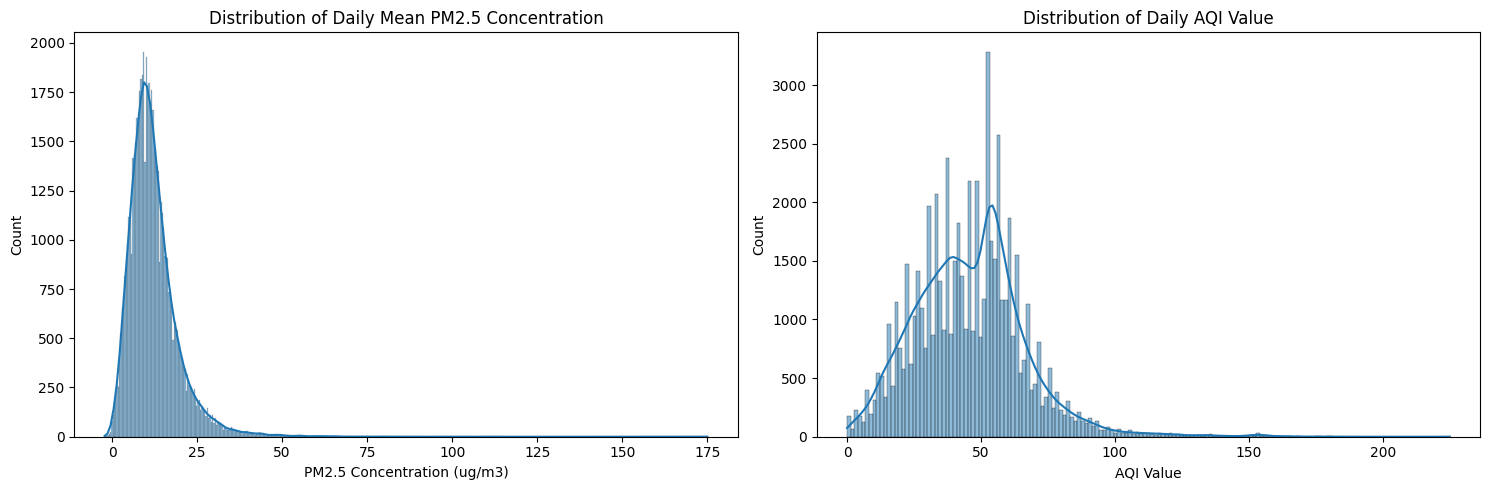

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert 'Date' column to datetime
air_quality_data['Date'] = pd.to_datetime(air_quality_data['Date'])

# Plotting distributions of key metrics: Daily Mean PM2.5 Concentration and DAILY_AQI_VALUE
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Distribution of Daily Mean PM2.5 Concentration
sns.histplot(air_quality_data['Daily Mean PM2.5 Concentration'], ax=axes[0], kde=True)
axes[0].set_title('Distribution of Daily Mean PM2.5 Concentration')
axes[0].set_xlabel('PM2.5 Concentration (ug/m3)')

# Distribution of DAILY_AQI_VALUE
sns.histplot(air_quality_data['DAILY_AQI_VALUE'], ax=axes[1], kde=True)
axes[1].set_title('Distribution of Daily AQI Value')
axes[1].set_xlabel('AQI Value')

plt.tight_layout()
plt.show()

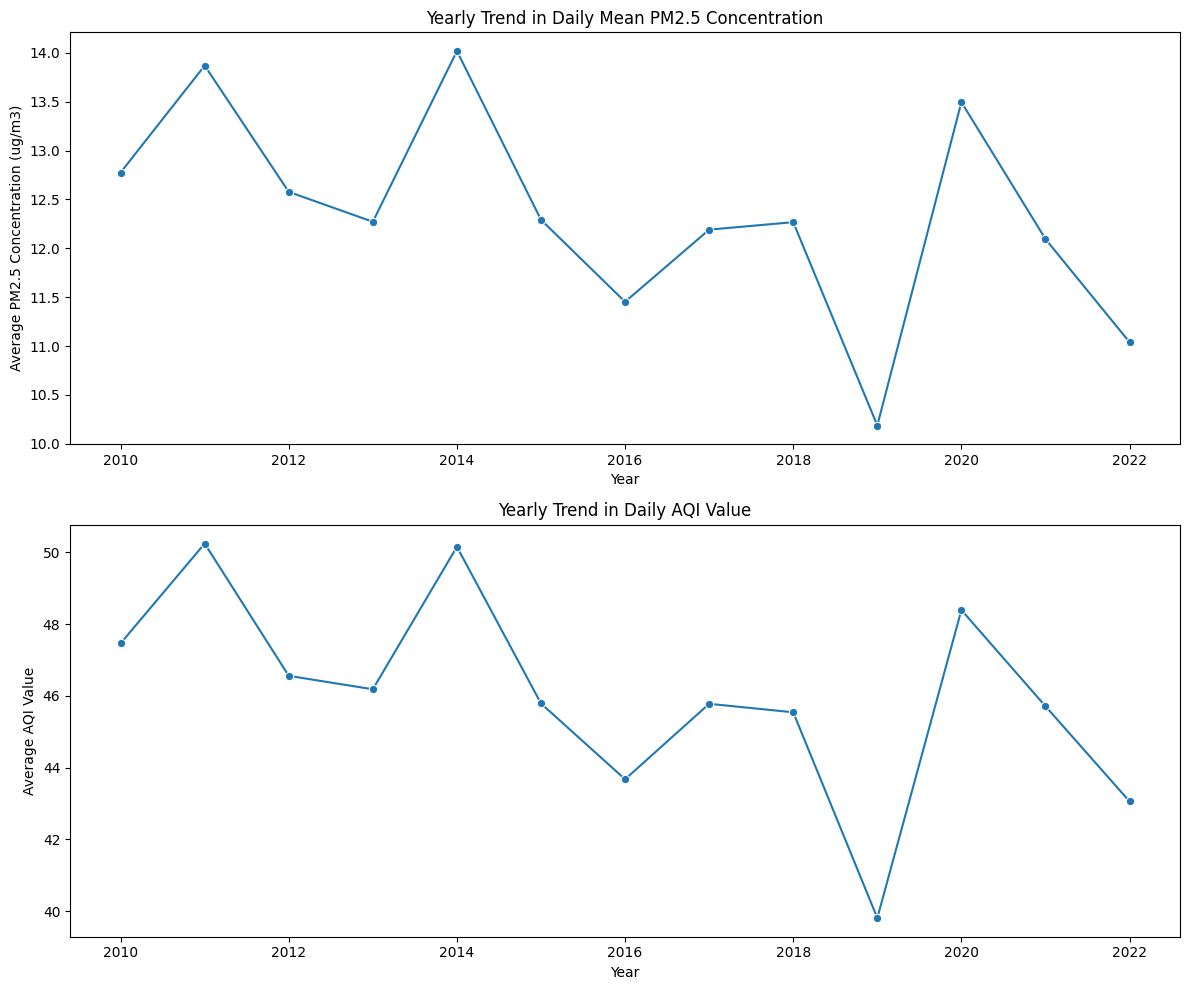

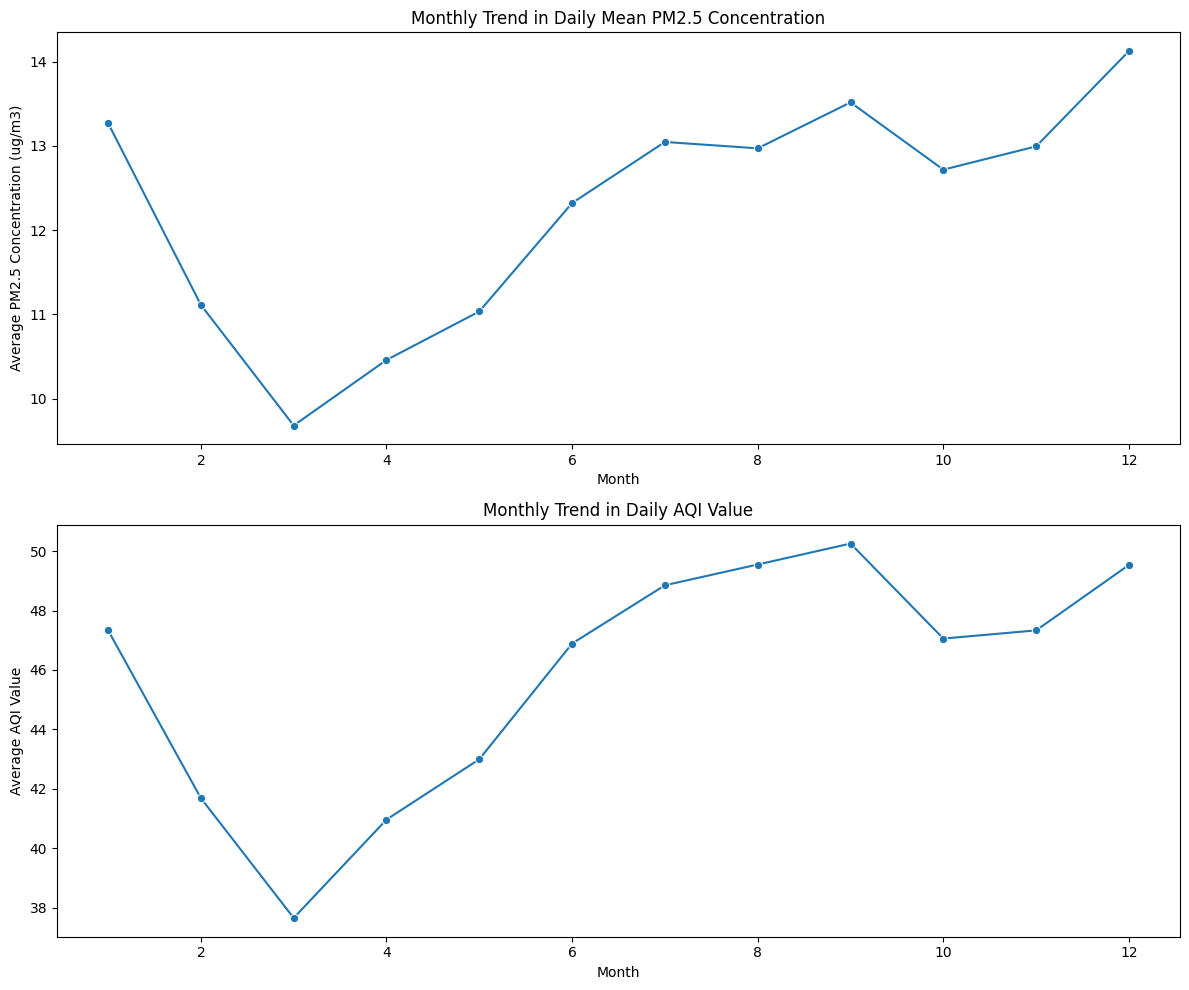

In [4]:
# Extracting year and month from the date for temporal analysis
air_quality_data['Year'] = air_quality_data['Date'].dt.year
air_quality_data['Month'] = air_quality_data['Date'].dt.month

# Grouping by year for yearly trends
yearly_data = air_quality_data.groupby('Year').agg({
    'Daily Mean PM2.5 Concentration': 'mean',
    'DAILY_AQI_VALUE': 'mean'
}).reset_index()

# Plotting yearly trends
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Yearly trend in PM2.5 Concentration
sns.lineplot(data=yearly_data, x='Year', y='Daily Mean PM2.5 Concentration', ax=axes[0], marker='o')
axes[0].set_title('Yearly Trend in Daily Mean PM2.5 Concentration')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Average PM2.5 Concentration (ug/m3)')

# Yearly trend in AQI Value
sns.lineplot(data=yearly_data, x='Year', y='DAILY_AQI_VALUE', ax=axes[1], marker='o')
axes[1].set_title('Yearly Trend in Daily AQI Value')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Average AQI Value')

plt.tight_layout()
plt.show()

# Grouping by month for seasonal trends
monthly_data = air_quality_data.groupby('Month').agg({
    'Daily Mean PM2.5 Concentration': 'mean',
    'DAILY_AQI_VALUE': 'mean'
}).reset_index()

# Plotting monthly trends
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Monthly trend in PM2.5 Concentration
sns.lineplot(data=monthly_data, x='Month', y='Daily Mean PM2.5 Concentration', ax=axes[0], marker='o')
axes[0].set_title('Monthly Trend in Daily Mean PM2.5 Concentration')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Average PM2.5 Concentration (ug/m3)')

# Monthly trend in AQI Value
sns.lineplot(data=monthly_data, x='Month', y='DAILY_AQI_VALUE', ax=axes[1], marker='o')
axes[1].set_title('Monthly Trend in Daily AQI Value')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Average AQI Value')

plt.tight_layout()
plt.show()


In [5]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points
    on the earth (specified in decimal degrees).
    """
    # Convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of earth in kilometers
    return c * r

# Central coordinates of Los Angeles (Downtown LA)
central_la_lon = -118.2437
central_la_lat = 34.0522

# Calculating the Haversine distance for each site
air_quality_data['Distance from Central LA'] = air_quality_data.apply(
    lambda row: haversine(central_la_lon, central_la_lat, row['SITE_LONGITUDE'], row['SITE_LATITUDE']), axis=1)

# Conducting correlation analysis with the new variable
correlation_with_distance = air_quality_data.corr()['Distance from Central LA'].sort_values(ascending=False)

correlation_with_distance

<ipython-input-5-15c2f7d83d1a>:28: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_with_distance = air_quality_data.corr()['Distance from Central LA'].sort_values(ascending=False)


Distance from Central LA          1.000000
SITE_LATITUDE                     0.548485
Site ID                           0.225853
COUNTY_CODE                       0.172208
AQS_PARAMETER_CODE                0.098258
Year                              0.072678
Month                             0.000222
SITE_LONGITUDE                   -0.151517
Daily Mean PM2.5 Concentration   -0.254919
POC                              -0.273601
DAILY_AQI_VALUE                  -0.312032
DAILY_OBS_COUNT                        NaN
PERCENT_COMPLETE                       NaN
CBSA_CODE                              NaN
STATE_CODE                             NaN
Name: Distance from Central LA, dtype: float64

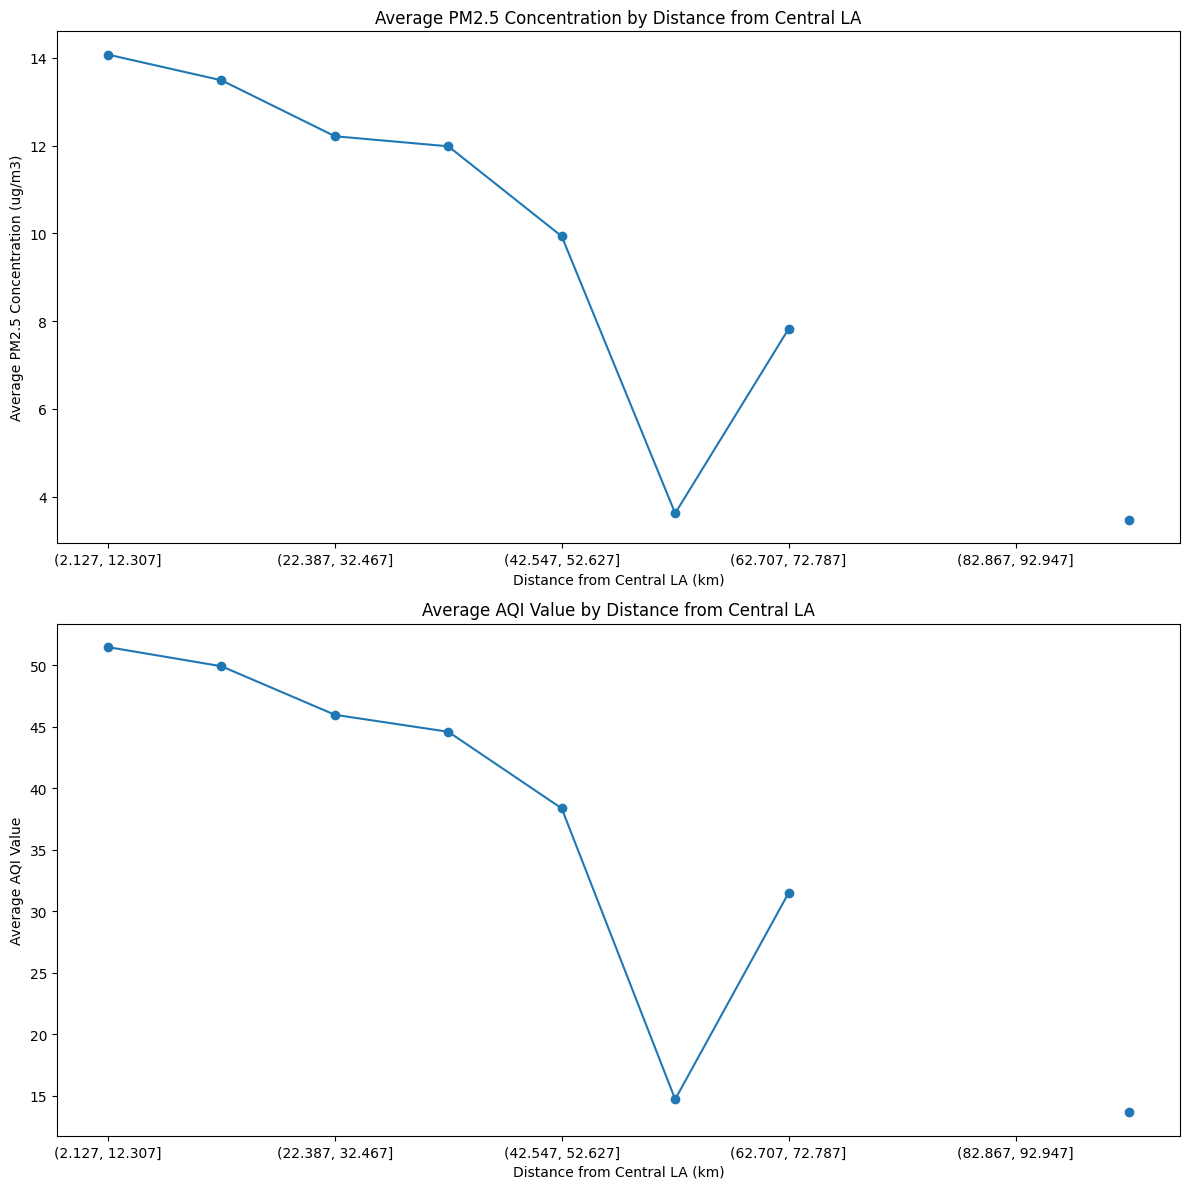

In [6]:
import matplotlib.pyplot as plt

# Grouping the data by distance intervals and calculating the average PM2.5 and AQI for each group
distance_bins = pd.cut(air_quality_data['Distance from Central LA'], bins=10)
avg_pm25_by_distance = air_quality_data.groupby(distance_bins)['Daily Mean PM2.5 Concentration'].mean()
avg_aqi_by_distance = air_quality_data.groupby(distance_bins)['DAILY_AQI_VALUE'].mean()

# Plotting
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# Average PM2.5 Concentration by Distance Range
avg_pm25_by_distance.plot(ax=axes[0], marker='o')
axes[0].set_title('Average PM2.5 Concentration by Distance from Central LA')
axes[0].set_xlabel('Distance from Central LA (km)')
axes[0].set_ylabel('Average PM2.5 Concentration (ug/m3)')

# Average AQI Value by Distance Range
avg_aqi_by_distance.plot(ax=axes[1], marker='o')
axes[1].set_title('Average AQI Value by Distance from Central LA')
axes[1].set_xlabel('Distance from Central LA (km)')
axes[1].set_ylabel('Average AQI Value')

plt.tight_layout()
plt.show()

Finding out that the 7th data point comes from Lancaster.

In [7]:
# Finding a representative site within the 7th bin's range
representative_site = air_quality_data[(air_quality_data['Distance from Central LA'] > 62.707) &
                                       (air_quality_data['Distance from Central LA'] <= 72.787)].iloc[0]

representative_location = {
    'Site ID': representative_site['Site ID'],
    'Latitude': representative_site['SITE_LATITUDE'],
    'Longitude': representative_site['SITE_LONGITUDE'],
    'Distance from Central LA': representative_site['Distance from Central LA']
}

representative_location


{'Site ID': 60379033,
 'Latitude': 34.6697390008831,
 'Longitude': -118.130511,
 'Distance from Central LA': 69.44875362968166}

Correlation analysis for date, and day of week.

In [10]:
import pandas as pd

# Convert 'Date' column to datetime
air_quality_data['Date'] = pd.to_datetime(air_quality_data['Date'])

# Extracting year, month, and day from the date
air_quality_data['Year'] = air_quality_data['Date'].dt.year
air_quality_data['Month'] = air_quality_data['Date'].dt.month
air_quality_data['Day'] = air_quality_data['Date'].dt.day

# Function to categorize data into seasons
def month_to_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
    else:  # December, January, February
        return 'Winter'

# Categorizing data into seasons
air_quality_data['Season'] = air_quality_data['Month'].apply(month_to_season)

# Adding a column to differentiate between weekdays and weekends
air_quality_data['Weekday/Weekend'] = air_quality_data['Date'].dt.dayofweek.apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

In [11]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Convert 'Date' to a numerical value (number of days since the start of the dataset)
air_quality_data['Date'] = pd.to_datetime(air_quality_data['Date'])
air_quality_data['Date_Num'] = (air_quality_data['Date'] - air_quality_data['Date'].min()).dt.days

# Convert 'Day Of Week' to numerical dummy variables
encoder = OneHotEncoder(sparse=False)
day_of_week_encoded = encoder.fit_transform(air_quality_data[['Day Of Week']])

# Create a DataFrame for the encoded day of the week
day_of_week_encoded_df = pd.DataFrame(day_of_week_encoded, columns=encoder.get_feature_names_out(['Day Of Week']))


from pandas.tseries.holiday import USFederalHolidayCalendar as Calendar

# Extract month from the date
air_quality_data['Month'] = air_quality_data['Date'].dt.month

# Determine if the date is a US federal holiday
cal = Calendar()
holidays = cal.holidays(start=air_quality_data['Date'].min(), end=air_quality_data['Date'].max())
air_quality_data['Holiday'] = air_quality_data['Date'].isin(holidays).astype(int)

# Determine if the date is a weekend (Saturday or Sunday)
air_quality_data['Weekend'] = air_quality_data['Date'].dt.dayofweek.isin([5, 6]).astype(int)

# Determine if the date is a weekday (Monday to Friday)
air_quality_data['Weekday'] = 1 - air_quality_data['Weekend']

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


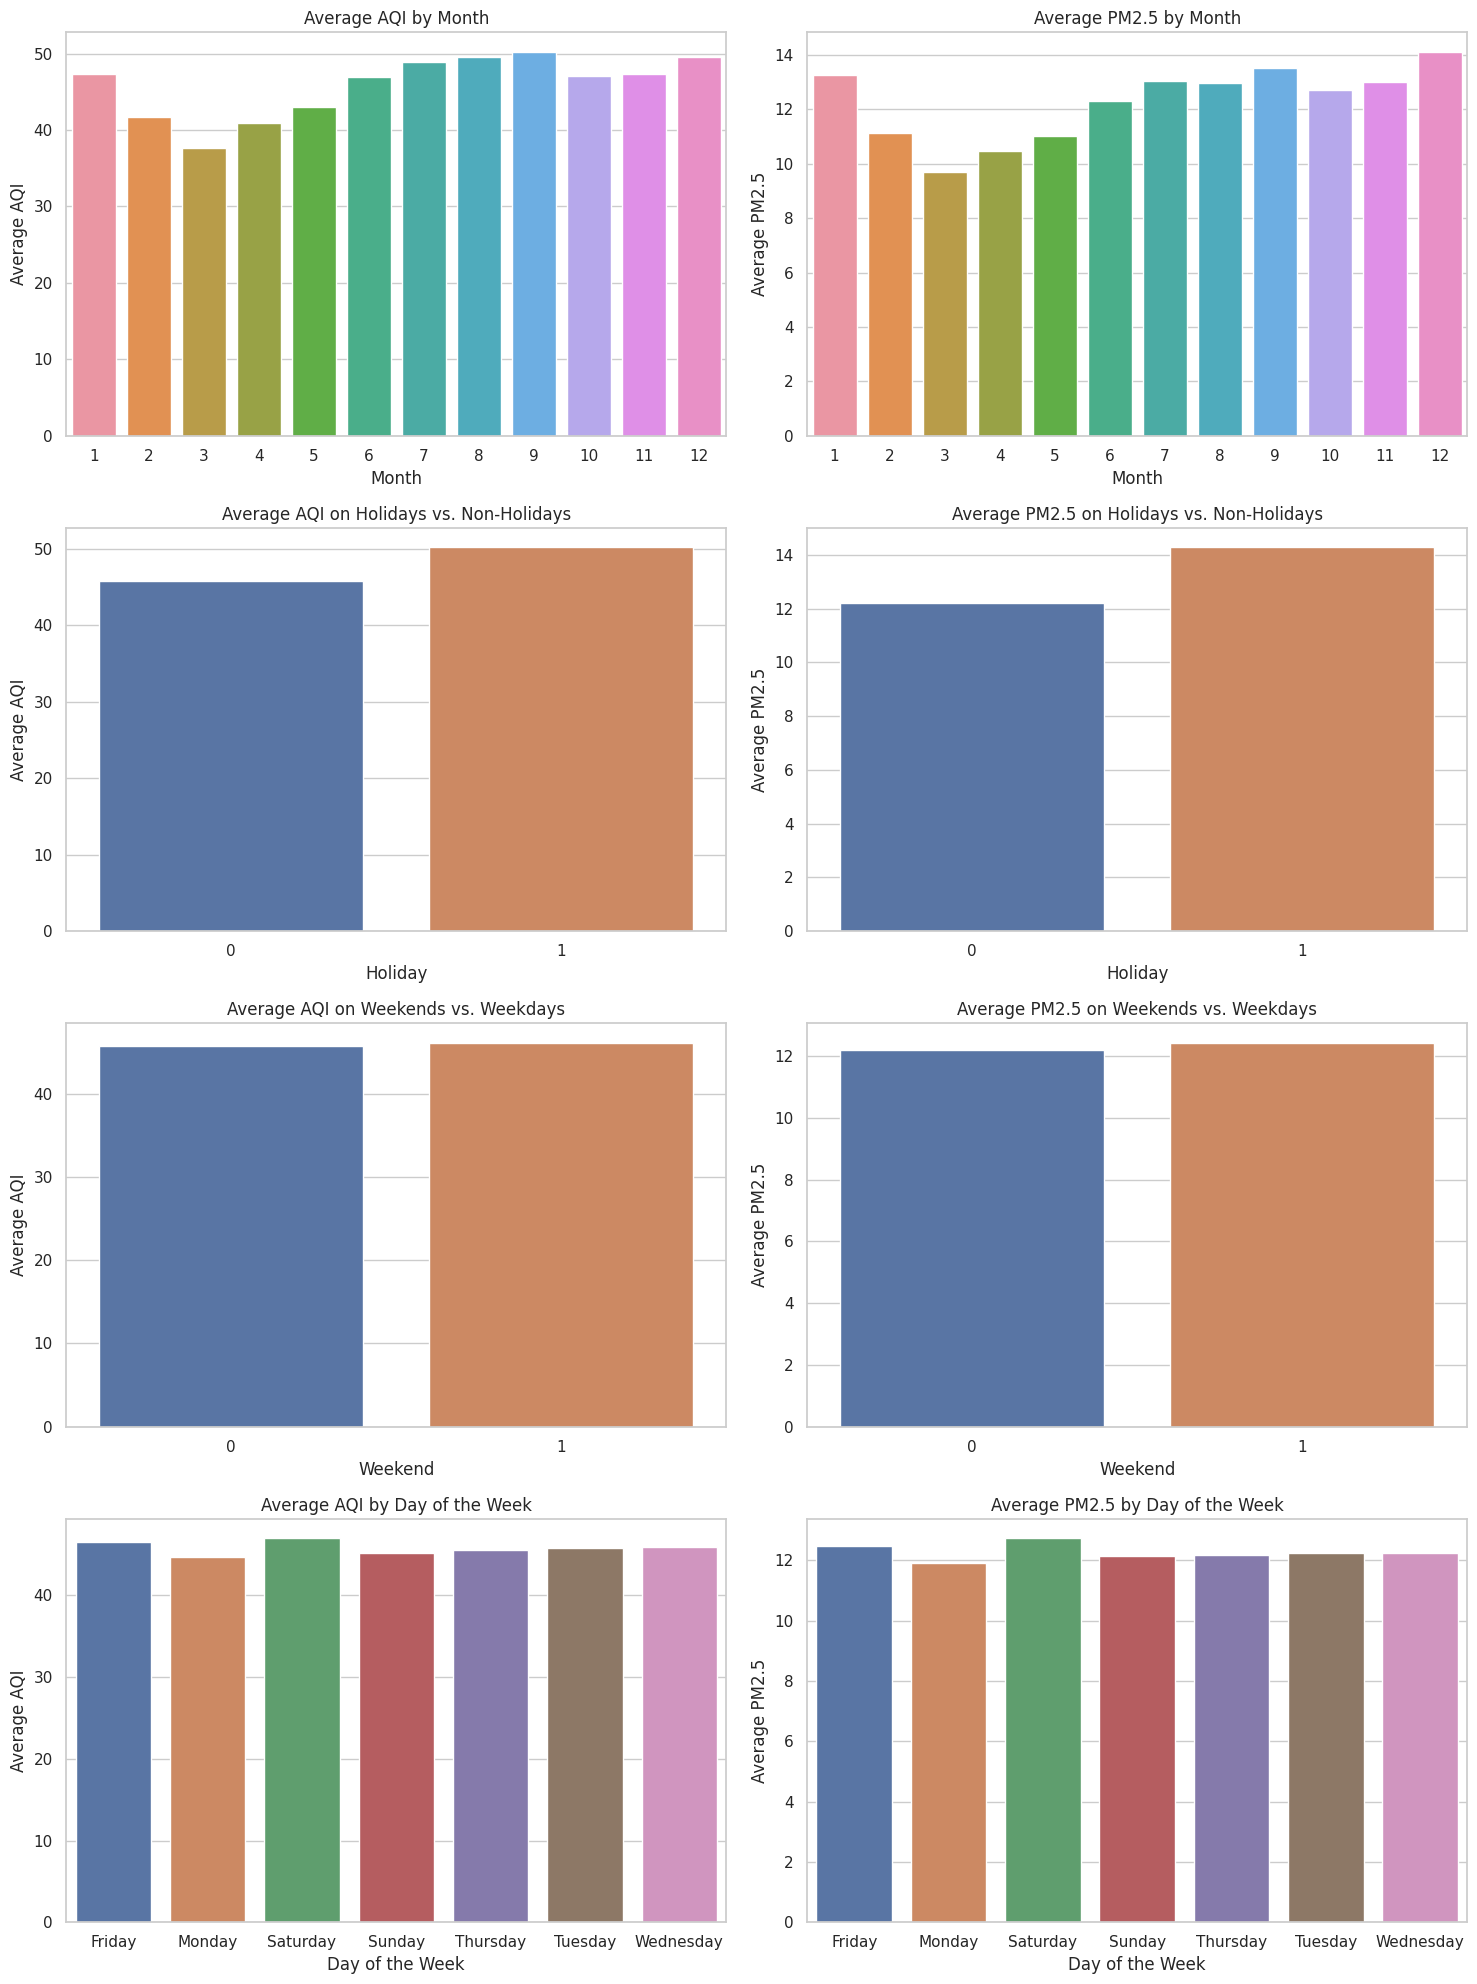

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetics for the plots
sns.set(style="whitegrid")

# Calculate the mean AQI and PM2.5 for each category
avg_aqi_month = air_quality_data.groupby('Month')['DAILY_AQI_VALUE'].mean()
avg_pm25_month = air_quality_data.groupby('Month')['Daily Mean PM2.5 Concentration'].mean()

avg_aqi_holiday = air_quality_data.groupby('Holiday')['DAILY_AQI_VALUE'].mean()
avg_pm25_holiday = air_quality_data.groupby('Holiday')['Daily Mean PM2.5 Concentration'].mean()

avg_aqi_weekend = air_quality_data.groupby('Weekend')['DAILY_AQI_VALUE'].mean()
avg_pm25_weekend = air_quality_data.groupby('Weekend')['Daily Mean PM2.5 Concentration'].mean()

avg_aqi_weekday = air_quality_data.groupby('Day Of Week')['DAILY_AQI_VALUE'].mean()
avg_pm25_weekday = air_quality_data.groupby('Day Of Week')['Daily Mean PM2.5 Concentration'].mean()

# Creating plots for each feature
fig, axs = plt.subplots(4, 2, figsize=(15, 20))

# Month
sns.barplot(x=avg_aqi_month.index, y=avg_aqi_month.values, ax=axs[0, 0])
axs[0, 0].set_title('Average AQI by Month')
axs[0, 0].set_xlabel('Month')
axs[0, 0].set_ylabel('Average AQI')

sns.barplot(x=avg_pm25_month.index, y=avg_pm25_month.values, ax=axs[0, 1])
axs[0, 1].set_title('Average PM2.5 by Month')
axs[0, 1].set_xlabel('Month')
axs[0, 1].set_ylabel('Average PM2.5')

# Holiday
sns.barplot(x=avg_aqi_holiday.index, y=avg_aqi_holiday.values, ax=axs[1, 0])
axs[1, 0].set_title('Average AQI on Holidays vs. Non-Holidays')
axs[1, 0].set_xlabel('Holiday')
axs[1, 0].set_ylabel('Average AQI')

sns.barplot(x=avg_pm25_holiday.index, y=avg_pm25_holiday.values, ax=axs[1, 1])
axs[1, 1].set_title('Average PM2.5 on Holidays vs. Non-Holidays')
axs[1, 1].set_xlabel('Holiday')
axs[1, 1].set_ylabel('Average PM2.5')

# Weekend
sns.barplot(x=avg_aqi_weekend.index, y=avg_aqi_weekend.values, ax=axs[2, 0])
axs[2, 0].set_title('Average AQI on Weekends vs. Weekdays')
axs[2, 0].set_xlabel('Weekend')
axs[2, 0].set_ylabel('Average AQI')

sns.barplot(x=avg_pm25_weekend.index, y=avg_pm25_weekend.values, ax=axs[2, 1])
axs[2, 1].set_title('Average PM2.5 on Weekends vs. Weekdays')
axs[2, 1].set_xlabel('Weekend')
axs[2, 1].set_ylabel('Average PM2.5')

# Day of the Week
sns.barplot(x=avg_aqi_weekday.index, y=avg_aqi_weekday.values, ax=axs[3, 0])
axs[3, 0].set_title('Average AQI by Day of the Week')
axs[3, 0].set_xlabel('Day of the Week')
axs[3, 0].set_ylabel('Average AQI')

sns.barplot(x=avg_pm25_weekday.index, y=avg_pm25_weekday.values, ax=axs[3, 1])
axs[3, 1].set_title('Average PM2.5 by Day of the Week')
axs[3, 1].set_xlabel('Day of the Week')
axs[3, 1].set_ylabel('Average PM2.5')

plt.tight_layout()
plt.show()

In [13]:
# Prepare the dataset for correlation analysis
correlation_data_aqi_pm25 = air_quality_data[['DAILY_AQI_VALUE', 'Daily Mean PM2.5 Concentration', 'Month', 'Holiday', 'Weekend', 'Weekday']]
correlation_data_aqi_pm25 = pd.concat([correlation_data_aqi_pm25, day_of_week_encoded_df], axis=1)

# Compute the correlation matrix
correlation_matrix_aqi_pm25 = correlation_data_aqi_pm25.corr()

# Extract the correlation values for AQI and PM2.5
correlation_aqi = correlation_matrix_aqi_pm25['DAILY_AQI_VALUE'].drop(['DAILY_AQI_VALUE', 'Daily Mean PM2.5 Concentration'])
correlation_pm25 = correlation_matrix_aqi_pm25['Daily Mean PM2.5 Concentration'].drop(['DAILY_AQI_VALUE', 'Daily Mean PM2.5 Concentration'])

correlation_aqi_pm25 = pd.DataFrame({'AQI': correlation_aqi, 'PM2.5': correlation_pm25})
correlation_aqi_pm25

,AQI,PM2.5
Month,0.121030,0.110211
Holiday,0.035778,0.045500
Weekend,0.009218,0.013602
Weekday,-0.009218,-0.013602
Day Of Week_Friday,0.013266,0.011533
Day Of Week_Monday,-0.021152,-0.020284
Day Of Week_Saturday,0.023662,0.025223
Day Of Week_Sunday,-0.011833,-0.007735
Day Of Week_Thursday,-0.004975,-0.006225
Day Of Week_Tuesday,-0.000939,-0.001800


Machine Learning

Transformer architecture

In [14]:
air_quality_data.columns

Index(['Date', 'Source', 'Site ID', 'POC', 'Daily Mean PM2.5 Concentration',
       'UNITS', 'DAILY_AQI_VALUE', 'Site Name', 'DAILY_OBS_COUNT',
       'PERCENT_COMPLETE', 'AQS_PARAMETER_CODE', 'AQS_PARAMETER_DESC',
       'CBSA_CODE', 'CBSA_NAME', 'STATE_CODE', 'STATE', 'COUNTY_CODE',
       'COUNTY', 'SITE_LATITUDE', 'SITE_LONGITUDE', 'Day Of Week', 'Year',
       'Month', 'Distance from Central LA', 'Day', 'Season', 'Weekday/Weekend',
       'Date_Num', 'Holiday', 'Weekend', 'Weekday'],
      dtype='object')

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = air_quality_data[['Daily Mean PM2.5 Concentration', 'Month', 'Distance from Central LA']]
y = air_quality_data['DAILY_AQI_VALUE']

# Normalizing features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [17]:
import tensorflow as tf
from tensorflow.keras import layers

def build_transformer_model(input_dim, num_heads, num_layers, dff, output_dim, rate=0.1):
    inputs = tf.keras.Input(shape=(input_dim,))
    x = layers.Dense(dff, activation='relu')(inputs)
    x = layers.Reshape((1, -1))(x)  # Reshape for transformer layer
    for _ in range(num_layers):
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=dff)(x, x)
        x = layers.Concatenate()([x, attention_output])
        x = layers.Dropout(rate)(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.Flatten()(x)  # Flatten before final layer
    outputs = layers.Dense(output_dim)(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [18]:
from tensorflow.keras.optimizers import Adam

model = build_transformer_model(input_dim=3, num_heads=2, num_layers=2, dff=64, output_dim=1)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

In [19]:
history = model.fit(X_train, y_train, batch_size=64, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
764/764 [==============================] - 16s 8ms/step - loss: 186.3289 - val_loss: 17.6726
Epoch 2/10
764/764 [==============================] - 8s 11ms/step - loss: 10.8148 - val_loss: 13.0912
Epoch 3/10
764/764 [==============================] - 6s 8ms/step - loss: 5.6149 - val_loss: 3.4615
Epoch 4/10
764/764 [==============================] - 10s 13ms/step - loss: 4.4605 - val_loss: 2.9949
Epoch 5/10
764/764 [==============================] - 10s 13ms/step - loss: 3.5873 - val_loss: 4.5063
Epoch 6/10
764/764 [==============================] - 6s 8ms/step - loss: 2.9947 - val_loss: 5.3488
Epoch 7/10
764/764 [==============================] - 7s 9ms/step - loss: 2.9140 - val_loss: 4.4055
Epoch 8/10
764/764 [==============================] - 7s 9ms/step - loss: 2.6826 - val_loss: 5.1103
Epoch 9/10
764/764 [==============================] - 7s 9ms/step - loss: 2.5142 - val_loss: 4.2260
Epoch 10/10
764/764 [==============================] - 6s 7ms/step - loss: 2.1238 - val_l

In [20]:
from sklearn.metrics import mean_absolute_error, r2_score

# Evaluate the model
test_loss = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Loss (MSE): {test_loss}")

# Make predictions
y_pred = model.predict(X_test)

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

# Calculate R-squared Score
r2 = r2_score(y_test, y_pred)
print(f"R-squared Score: {r2}")

382/382 - 1s - loss: 4.3098 - 1s/epoch - 3ms/step
Test Loss (MSE): 4.309800624847412
382/382 [==============================] - 1s 3ms/step
Mean Absolute Error: 1.328294925472758
R-squared Score: 0.9900344663011929


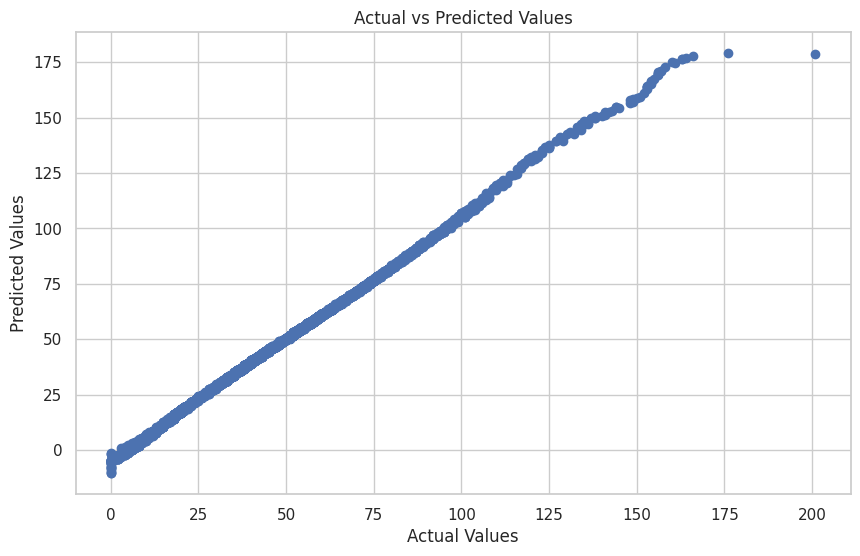

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

Linear regression and decision tree models

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Selecting the feature and target variable
X = air_quality_data[['Daily Mean PM2.5 Concentration', 'Distance from Central LA', 'Month'
       ]]
y = air_quality_data['DAILY_AQI_VALUE']

In [24]:
# Create the 'outliers' feature
air_quality_data['Holiday'] = 0

# New Year's Day
air_quality_data.loc[(air_quality_data['Date'].dt.month == 1) & (air_quality_data['Date'].dt.day == 1), 'Holiday'] = 1

# Independence Day
air_quality_data.loc[(air_quality_data['Date'].dt.month == 7) & (air_quality_data['Date'].dt.day == 4), 'Holiday'] = 1

# Thanksgiving (fourth Thursday of November)
thanksgiving_dates = air_quality_data[(air_quality_data['Date'].dt.month == 11) &
                                      (air_quality_data['Date'].dt.day_name() == 'Thursday') &
                                      (air_quality_data['Date'].dt.day > 21) &
                                      (air_quality_data['Date'].dt.day <= 28)]['Date'].unique()
air_quality_data.loc[air_quality_data['Date'].isin(thanksgiving_dates), 'Holiday'] = 1

# Christmas
air_quality_data.loc[(air_quality_data['Date'].dt.month == 12) & (air_quality_data['Date'].dt.day == 25), 'Holiday'] = 1

# Selecting the relevant features for X, now including 'Holiday'
X = air_quality_data[['Daily Mean PM2.5 Concentration', 'Holiday', 'Distance from Central LA', 'Month']]

# Display the first few rows of the updated feature set
X.head()

,Daily Mean PM2.5 Concentration,Holiday,Distance from Central LA,Month
0,15.9,1,2.227362,1
1,26.5,1,29.573557,1
2,5.8,1,45.187043,1
3,13.1,1,2.227362,1
4,21.8,1,15.340774,1


In [35]:
# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
linear_model = LinearRegression()
tree_model = DecisionTreeRegressor(random_state=42)

# Training the models
linear_model.fit(X_train, y_train)
tree_model.fit(X_train, y_train)

# Predicting on the test set
y_pred_linear = linear_model.predict(X_test)
y_pred_tree = tree_model.predict(X_test)

# Model evaluation
eval_metrics_linear = {
    'MAE': mean_absolute_error(y_test, y_pred_linear),
    'MSE': mean_squared_error(y_test, y_pred_linear),
    'R2 Score': r2_score(y_test, y_pred_linear)
}

eval_metrics_tree = {
    'MAE': mean_absolute_error(y_test, y_pred_tree),
    'MSE': mean_squared_error(y_test, y_pred_tree),
    'R2 Score': r2_score(y_test, y_pred_tree)
}

print('Linear Regression metrics: ', eval_metrics_linear)
print()
print('Decision Tree metrics: ', eval_metrics_tree)

Linear Regression metrics:  {'MAE': 3.4950426521887246, 'MSE': 23.403721480216227, 'R2 Score': 0.9458836790864088}

Decision Tree metrics:  {'MAE': 0.0012273954668194091, 'MSE': 0.0015547009246379183, 'R2 Score': 0.9999964050719783}


Metrics for different features

'Daily Mean PM2.5 Concentration'
({'MAE': 3.652291973628369,
  'MSE': 25.867045891398547,
  'R2 Score': 0.9401877450247035},
 {'MAE': 0.0009000900090009,
  'MSE': 0.0010637427379101548,
  'R2 Score': 0.9999975403124062})

'Daily Mean PM2.5 Concentration', 'Distance from Central LA'
({'MAE': 3.517830163622977,
  'MSE': 23.75385751771952,
  'R2 Score': 0.9450740610867688},
 {'MAE': 0.0010637427379101548,
  'MSE': 0.0012273954668194091,
  'R2 Score': 0.9999971618989302})

  'Daily Mean PM2.5 Concentration', 'Distance from Central LA', 'Month'
  ({'MAE': 3.510488624542874,
  'MSE': 23.630630151715657,
  'R2 Score': 0.9453589991761936},
 {'MAE': 0.0009819163734555273,
  'MSE': 0.001145569102364782,
  'R2 Score': 0.9999973511056682})

({'MAE': 3.495042652188726,
  'MSE': 23.403721480216227,
  'R2 Score': 0.9458836790864088},
 {'MAE': 0.0012273954668194091,
  'MSE': 0.0015547009246379183,
  'R2 Score': 0.9999964050719783})